We'll start by importing all necessary libraries.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import tree
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import visualkeras
import tensorflow as tf
tf.data.experimental.enable_debug_mode()
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm_notebook
from sklearn.tree import export_graphviz

Loading the two datasets that will be used. The '15-'16 season will be used for training, while the next season is used for testing

In [2]:
df_train1 = pd.read_csv('data/NBA_PBP_2015-16.csv')
df_train2 = pd.read_csv('data/NBA_PBP_2016-17.csv')
df_train3 = pd.read_csv('data/NBA_PBP_2017-18.csv')
df_train4 = pd.read_csv('data/NBA_PBP_2018-19.csv')
df_train5 = pd.read_csv('data/NBA_PBP_2019-20.csv')

del df_train5['Unnamed: 40']

df_train = pd.concat([df_train1, df_train2, df_train3, df_train4, df_train5])

df_train.to_csv('all_seasons.csv', index=False)

# df_test = pd.read_csv('test data/NBA_PBP_2020-21.csv')

In [3]:
df_train = df_train.reset_index(drop=True)

Below, we have the selected features and a list of their names for the feature vectors that will be constructed later.

In [4]:
factors = ['ShotDist','TimeoutTeam','Substitution', 'Shooter',
           'Rebounder', 'Blocker','Fouler',
          'ReboundType','ViolationPlayer',
          'FreeThrowShooter','TurnoverPlayer']

fact_cols = [col + str((i // 11) % 10 + 1) for i, col in enumerate(factors * 10)]
fact_cols.append('class')

In [5]:
df_train['ShotDist'] = df_train.ShotDist.apply(lambda x: 'close' if x <= 10 else '3pt' if x >= 22 else 'mid' if pd.notna(x) else x)
# df_train['FoulType'] = df_train.FoulType.apply(lambda x: 'foul' if pd.notna(x) else x)
# df_train['ViolationType'] = df_train.ViolationType.apply(lambda x: 'violation' if pd.notna(x) else x)
# df_train['TurnoverType'] = df_train.TurnoverType.apply(lambda x: 'turnover' if pd.notna(x) else x)
df_train['TimeoutTeam'] = df_train.apply(
    lambda row: 'timeout_home' if pd.notna(row['TimeoutTeam']) and row['TimeoutTeam'] == row['HomeTeam'] 
    else 'timeout_away' if pd.notna(row['TimeoutTeam']) 
    else row['TimeoutTeam'], 
    axis=1
)

# df_train['TurnoverType'] = df_train.apply(lambda row: 'turnover_home' if pd.notna(row['TurnoverType']) and pd.notna(row['HomePlay'])
#                                      else 'turnover_away' if pd.notna(row['TurnoverType']) and pd.notna(row['AwayPlay'])
#                                      else np.nan,
#                                      axis=1)

# df_train['ViolationType'] = df_train.apply(lambda row: 'violation_home' if pd.notna(row['ViolationType']) and pd.notna(row['HomePlay'])
#                                      else 'violation_away' if pd.notna(row['ViolationType']) and pd.notna(row['AwayPlay'])
#                                      else np.nan,
#                                      axis=1)

# df_train['FoulType'] = df_train.apply(lambda row: 'foul_home' if pd.notna(row['FoulType']) and pd.notna(row['HomePlay'])
#                                      else 'foul_away' if pd.notna(row['FoulType']) and pd.notna(row['AwayPlay'])
#                                      else np.nan,
#                                      axis=1)

df_train['Shooter'] = df_train.apply(lambda row: 'shooter_home' if pd.notna(row['Shooter']) and pd.notna(row['HomePlay'])
                                     else 'shooter_away' if pd.notna(row['Shooter']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['Rebounder'] = df_train.apply(lambda row: 'rebounder_home' if pd.notna(row['Rebounder']) and pd.notna(row['HomePlay'])
                                     else 'rebounder_away' if pd.notna(row['Rebounder']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['Blocker'] = df_train.apply(lambda row: 'blocker_home' if pd.notna(row['Blocker']) and pd.notna(row['HomePlay'])
                                     else 'blocker_away' if pd.notna(row['Blocker']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['Fouler'] = df_train.apply(lambda row: 'fouler_home' if pd.notna(row['Fouler']) and pd.notna(row['HomePlay'])
                                     else 'fouler_away' if pd.notna(row['Fouler']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

# df_train['Fouled'] = df_train.apply(lambda row: 'fouled_home' if pd.notna(row['Fouled']) and pd.notna(row['HomePlay'])
#                                      else 'fouled_away' if pd.notna(row['Fouled']) and pd.notna(row['AwayPlay'])
#                                      else np.nan,
#                                      axis=1)

df_train['ViolationPlayer'] = df_train.apply(lambda row: 'violator_home' if pd.notna(row['ViolationPlayer']) and pd.notna(row['HomePlay'])
                                     else 'violator_away' if pd.notna(row['ViolationPlayer']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['FreeThrowShooter'] = df_train.apply(lambda row: 'ft_home' if pd.notna(row['FreeThrowShooter']) and pd.notna(row['HomePlay'])
                                     else 'ft_away' if pd.notna(row['FreeThrowShooter']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['TurnoverPlayer'] = df_train.apply(lambda row: 'to_player_home' if pd.notna(row['TurnoverPlayer']) and pd.notna(row['HomePlay'])
                                     else 'to_player_away' if pd.notna(row['TurnoverPlayer']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

# df_train['TurnoverCauser'] = df_train.apply(lambda row: 'to_causer_home' if pd.notna(row['TurnoverCauser']) and pd.notna(row['HomePlay'])
#                                      else 'to_causer_away' if pd.notna(row['TurnoverCauser']) and pd.notna(row['AwayPlay'])
#                                      else np.nan,
#                                      axis=1)

df_train['Substitution'] = df_train.apply(lambda row: 'sub_home' if pd.notna(row['EnterGame']) and pd.notna(row['HomePlay'])
                                              else 'sub_away' if pd.notna(row['EnterGame']) and pd.notna(row['AwayPlay'])
                                              else np.nan,
                                              axis=1)



The encoders() function creates a different label encoder instance for each feature so that they can be encoded and decoded independently.

The next two functions iterate over the whole dataframe and creates lists of the moments a basket that contributes to a run occurs.


In [6]:
def home_runner(data):
    global home_runs
    run = []
    home_runs = []
    for idx in data.index:
        if data.at[idx,'HomePlay'] is not np.nan:
                if 'makes' in data.at[idx,'HomePlay']:
                    run.append(idx)
        elif data.at[idx,'AwayPlay'] is not np.nan:
                if 'makes' in data.at[idx,'AwayPlay']:
                    run.clear()
        if len(run) == 4:
            home_runs.append(run.copy())
            run.clear()
    return home_runs
                

home_runner(df_train)



def away_runner(data):
    global away_runs
    run = []
    away_runs = []
    for idx in data.index:
        if data.at[idx,'AwayPlay'] is not np.nan:
                if 'makes' in data.at[idx,'AwayPlay']:
                    run.append(idx)
        elif data.at[idx,'HomePlay'] is not np.nan:
                if 'makes' in data.at[idx,'HomePlay']:
                    run.clear()
        if len(run) == 4:
            away_runs.append(run.copy())
            run.clear()
    return away_runs

away_runner(df_train)

all_runs = []
all_runs.extend(home_runs)
all_runs.extend(away_runs)


The runs_iter() function looks for 10 events before the start of the run. It then picks specific columns of interest. The data from those columns get flattened in an 1d array, which is then added to a new dataframe, along with a label that indicates this is a run.

In [7]:
df_train = df_train[factors]

In [57]:
#The data from those columns get flattened in an 1d array, which is then added to a new dataframe, along with a label
#that indicates this is a run.

def runs_iter(data, runs):
    global runs_df
    runs_df = pd.DataFrame()
    for run in runs:
        a = data.loc[run[0]-10:run[0]-1, factors].values.ravel()
        a = np.append(a,1)
        runs_df = pd.concat([runs_df,pd.DataFrame([a.copy()])])
    return runs_df

runs_iter(df_train, home_runs)
runs_df.columns = fact_cols
runs_df

,ShotDist1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,ReboundType1,ViolationPlayer1,FreeThrowShooter1,TurnoverPlayer1,ShotDist2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,ReboundType2,ViolationPlayer2,FreeThrowShooter2,TurnoverPlayer2,ShotDist3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,ReboundType3,ViolationPlayer3,FreeThrowShooter3,TurnoverPlayer3,ShotDist4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,ReboundType4,ViolationPlayer4,FreeThrowShooter4,TurnoverPlayer4,ShotDist5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,ReboundType5,ViolationPlayer5,FreeThrowShooter5,TurnoverPlayer5,ShotDist6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,ReboundType6,ViolationPlayer6,FreeThrowShooter6,TurnoverPlayer6,ShotDist7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,ReboundType7,ViolationPlayer7,FreeThrowShooter7,TurnoverPlayer7,ShotDist8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,ReboundType8,ViolationPlayer8,FreeThrowShooter8,TurnoverPlayer8,ShotDist9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,ReboundType9,ViolationPlayer9,FreeThrowShooter9,TurnoverPlayer9,ShotDist10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,ReboundType10,ViolationPlayer10,FreeThrowShooter10,TurnoverPlayer10,class
0,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,mid,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,1
0,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
0,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
0,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,NaN,timeout_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home

The precipitating events for the runs are removed from the dataframe and a similar function assigns labels of 0 to no_runs.

In [58]:
def no_runs_preprocessing(data, runs):
    global no_runs_split
    
    # find the first index of a run
    r = [i[0] for i in runs]  

    # create a list of runs
    r_x = []
    for num in r:
        r_x.extend(range(num - 10, num + 1))

    # mask the df without runs
    no_runs_df = data[~data.index.isin(r_x)].reset_index(drop=True)

    # segment the df and keep those that are length of 10
    segment_size = 10
    segments = len(no_runs_df) // segment_size

    no_runs_split = np.array_split(no_runs_df, segments)

    no_runs_split = [x for x in no_runs_split if len(x) != 11]

    return no_runs_split

In [59]:
def no_runs_optimized(data, factors, fact_cols):
    global no_runs_df
    no_runs_df = pd.DataFrame([np.append(segment.loc[:, factors].values.ravel(), int(0)) for segment in data])
    no_runs_df.columns = fact_cols
    return no_runs_df

no_runs_optimized(no_runs_preprocessing(df_train, home_runs), factors, fact_cols)

,ShotDist1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,ReboundType1,ViolationPlayer1,FreeThrowShooter1,TurnoverPlayer1,ShotDist2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,ReboundType2,ViolationPlayer2,FreeThrowShooter2,TurnoverPlayer2,ShotDist3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,ReboundType3,ViolationPlayer3,FreeThrowShooter3,TurnoverPlayer3,ShotDist4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,ReboundType4,ViolationPlayer4,FreeThrowShooter4,TurnoverPlayer4,ShotDist5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,ReboundType5,ViolationPlayer5,FreeThrowShooter5,TurnoverPlayer5,ShotDist6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,ReboundType6,ViolationPlayer6,FreeThrowShooter6,TurnoverPlayer6,ShotDist7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,ReboundType7,ViolationPlayer7,FreeThrowShooter7,TurnoverPlayer7,ShotDist8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,ReboundType8,ViolationPlayer8,FreeThrowShooter8,TurnoverPlayer8,ShotDist9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,ReboundType9,ViolationPlayer9,FreeThrowShooter9,TurnoverPlayer9,ShotDist10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,ReboundType10,ViolationPlayer10,FreeThrowShooter10,TurnoverPlayer10,class
0,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,0
1,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,violator_home,NaN,NaN,mid,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,NaN,timeout_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_home,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_aw

To avoid label imbalance, we'll undersample the no_runs dataframe.

In [60]:
# no_runs_df=no_runs_df.sample(frac=0.14)

We'll combine the two frames into a final one.

In [61]:
combined_df = pd.concat([runs_df,no_runs_df],ignore_index=True)
# final_df = combined_df.dropna().astype(int)
combined_df

,ShotDist1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,ReboundType1,ViolationPlayer1,FreeThrowShooter1,TurnoverPlayer1,ShotDist2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,ReboundType2,ViolationPlayer2,FreeThrowShooter2,TurnoverPlayer2,ShotDist3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,ReboundType3,ViolationPlayer3,FreeThrowShooter3,TurnoverPlayer3,ShotDist4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,ReboundType4,ViolationPlayer4,FreeThrowShooter4,TurnoverPlayer4,ShotDist5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,ReboundType5,ViolationPlayer5,FreeThrowShooter5,TurnoverPlayer5,ShotDist6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,ReboundType6,ViolationPlayer6,FreeThrowShooter6,TurnoverPlayer6,ShotDist7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,ReboundType7,ViolationPlayer7,FreeThrowShooter7,TurnoverPlayer7,ShotDist8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,ReboundType8,ViolationPlayer8,FreeThrowShooter8,TurnoverPlayer8,ShotDist9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,ReboundType9,ViolationPlayer9,FreeThrowShooter9,TurnoverPlayer9,ShotDist10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,ReboundType10,ViolationPlayer10,FreeThrowShooter10,TurnoverPlayer10,class
0,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,mid,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,1
1,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,NaN,timeout_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home

In [62]:
combined_df.to_csv('home_runs.csv', index=False)

In [63]:
from sklearn.preprocessing import LabelEncoder

In [10]:
combined_df.dtypes

Unnamed: 0             int64
ShotDist1             object
TimeoutTeam1          object
Substitution1         object
Shooter1              object
                       ...  
ReboundType10         object
ViolationPlayer10     object
FreeThrowShooter10    object
TurnoverPlayer10      object
class                  int64
Length: 112, dtype: object

In [2]:
combined_df = pd.read_csv('home_runs.csv')
combined_df

C:\Users\gsevr\AppData\Local\Temp\ipykernel_7032\2790771757.py:1: DtypeWarning: Columns (104) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv('home_runs.csv')


,ShotDist1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,ReboundType1,ViolationPlayer1,FreeThrowShooter1,TurnoverPlayer1,ShotDist2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,ReboundType2,ViolationPlayer2,FreeThrowShooter2,TurnoverPlayer2,ShotDist3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,ReboundType3,ViolationPlayer3,FreeThrowShooter3,TurnoverPlayer3,ShotDist4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,ReboundType4,ViolationPlayer4,FreeThrowShooter4,TurnoverPlayer4,ShotDist5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,ReboundType5,ViolationPlayer5,FreeThrowShooter5,TurnoverPlayer5,ShotDist6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,ReboundType6,ViolationPlayer6,FreeThrowShooter6,TurnoverPlayer6,ShotDist7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,ReboundType7,ViolationPlayer7,FreeThrowShooter7,TurnoverPlayer7,ShotDist8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,ReboundType8,ViolationPlayer8,FreeThrowShooter8,TurnoverPlayer8,ShotDist9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,ReboundType9,ViolationPlayer9,FreeThrowShooter9,TurnoverPlayer9,ShotDist10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,ReboundType10,ViolationPlayer10,FreeThrowShooter10,TurnoverPlayer10,class
0,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,mid,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,1
1,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,NaN,timeout_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home

In [3]:
df = pd.DataFrame()
encoders = []

for column in combined_df.columns[:-1]:
    le = LabelEncoder()
    encoders.append(le)
    df[column] = le.fit_transform(combined_df[column])

df

C:\Users\gsevr\AppData\Local\Temp\ipykernel_7032\1549463531.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column] = le.fit_transform(combined_df[column])
C:\Users\gsevr\AppData\Local\Temp\ipykernel_7032\1549463531.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column] = le.fit_transform(combined_df[column])
C:\Users\gsevr\AppData\Local\Temp\ipykernel_7032\1549463531.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

,ShotDist1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,ReboundType1,ViolationPlayer1,FreeThrowShooter1,TurnoverPlayer1,ShotDist2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,ReboundType2,ViolationPlayer2,FreeThrowShooter2,TurnoverPlayer2,ShotDist3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,ReboundType3,ViolationPlayer3,FreeThrowShooter3,TurnoverPlayer3,ShotDist4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,ReboundType4,ViolationPlayer4,FreeThrowShooter4,TurnoverPlayer4,ShotDist5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,ReboundType5,ViolationPlayer5,FreeThrowShooter5,TurnoverPlayer5,ShotDist6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,ReboundType6,ViolationPlayer6,FreeThrowShooter6,TurnoverPlayer6,ShotDist7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,ReboundType7,ViolationPlayer7,FreeThrowShooter7,TurnoverPlayer7,ShotDist8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,ReboundType8,ViolationPlayer8,FreeThrowShooter8,TurnoverPlayer8,ShotDist9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,ReboundType9,ViolationPlayer9,FreeThrowShooter9,TurnoverPlayer9,ShotDist10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,ReboundType10,ViolationPlayer10,FreeThrowShooter10,TurnoverPlayer10
0,3,2,2,2,2,2,0,2,2,2,2,3,2,2,2,2,2,2,2,2,0,2,1,2,2,1,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,2,2,2,1,2,2,2,2,2,2,2,3,2,2,2,0,2,2,0,2,2,2,1,2,2,0,2,2,2,2,2,2,2,3,2,2,2,2,2,2,2,2,2,1,3,2,2,2,2,2,2,2,2,2,0
1,3,2,2,2,0,2,2,1,2,2,2,1,2,2,0,2,2,2,2,2,2,2,3,2,2,2,0,2,2,1,2,2,2,1,2,2,0,2,2,2,2,2,2,2,3,2,2,2,2,2,1,2,2,2,2,3,2,2,2,2,2,2,2,2,1,2,3,2,2,2,1,2,2,1,2,2,2,3,2,0,2,2,2,2,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2
2,1,2,2,1,2,2,2,2,2,2,2,3,2,2,2,0,2,2,0,2,2,2,0,2,2,0,2,2,2,2,2,2,2,3,2,2,2,0,2,2,1,2,2,2,3,2,0,2,2,2,2,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,0,2,2,1,2,2,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,2
3,0,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,3,0,2,2,2,2,2,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,3,2,2,2,2,2,1,2,2,2,2,3,2,2,2,2,2,1,2,2,2,2,3,2,2,2,2,2,2,2,2,1,2,3,2,2,2,1,2,2,1,2,2,2,3,2,0,2,2,2,2,2,2,2,2
4,3,2,2,2,2,2,2,2,2,2,0,1,2,2,1,2,2,2,2,2,2,2,1,2,2,0,2,2,2,2,2,2,2,0,2,2,1,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,1,2,2,1,2,2,2,2,2,2,2,3,2,2,2,2,2,1,2,2,2,2,3,2,2,2,2,2,2,2,2,1,2,3,2,2,2,0,2,2,0,2,2,2,1,2,2,0,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292442,1,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,0,2,2,1,2,2,2,2,2,2,2,3,2,2,2,1,2,2,1,2,2,2,1,2,2,1,2,2,2,2,2,2,2,3,2,2,2,1,2,2,1,2,2,2,1,2,2,1,2,2,2,2,2,2,2,3,2,2,2,2,2,0,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,1,2,2,0,2,0,2,2,2,2,2
292443,3,2,2,2,0,2,2,1,2,2,2,3,2,2,2,2,2,2,2,2,2,0,1,2,2,1,2,2,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,2,1,2,2,1,2,2,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,3,2,2,2,2,2,2,2,2,2,1,3,2,2,2,2,2,2,2,2,2,0,3,2,0,2,2,2,2,2,2,2,2
292444,3,2,2,2,2,2,2,2,2,2,1,3,0,2,2,2,2,2,2,2,2,2,1,2,2,0,2,2,2,2,2,2,2,3,2,2,2,2,2,0,2,2,2,2,3,2,2,2,2,2,2,2,2,1,2,3,2,2,2,2,2,1,2,2,2,2,1,2,2,1,2,2,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,2,3,2,2,2,2,2,1,2,2,2,2,0,2,2,1,2,2,2,2,2,2,2
292445,3,2,2,2,2,2,2,2,2,2,0,0,2,2,1,2,2,2,2,2,2,2,3,0,2,2,2,2,2,2,2,2,2,3,2,0,2,2,2,2,2,2,2,2,3,2,0,2,2,2,2,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,3,2,0,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2


In [4]:
df = pd.concat([df,combined_df.iloc[:,-1]],axis=1)
df

,ShotDist1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,ReboundType1,ViolationPlayer1,FreeThrowShooter1,TurnoverPlayer1,ShotDist2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,ReboundType2,ViolationPlayer2,FreeThrowShooter2,TurnoverPlayer2,ShotDist3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,ReboundType3,ViolationPlayer3,FreeThrowShooter3,TurnoverPlayer3,ShotDist4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,ReboundType4,ViolationPlayer4,FreeThrowShooter4,TurnoverPlayer4,ShotDist5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,ReboundType5,ViolationPlayer5,FreeThrowShooter5,TurnoverPlayer5,ShotDist6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,ReboundType6,ViolationPlayer6,FreeThrowShooter6,TurnoverPlayer6,ShotDist7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,ReboundType7,ViolationPlayer7,FreeThrowShooter7,TurnoverPlayer7,ShotDist8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,ReboundType8,ViolationPlayer8,FreeThrowShooter8,TurnoverPlayer8,ShotDist9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,ReboundType9,ViolationPlayer9,FreeThrowShooter9,TurnoverPlayer9,ShotDist10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,ReboundType10,ViolationPlayer10,FreeThrowShooter10,TurnoverPlayer10,class
0,3,2,2,2,2,2,0,2,2,2,2,3,2,2,2,2,2,2,2,2,0,2,1,2,2,1,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,2,2,2,1,2,2,2,2,2,2,2,3,2,2,2,0,2,2,0,2,2,2,1,2,2,0,2,2,2,2,2,2,2,3,2,2,2,2,2,2,2,2,2,1,3,2,2,2,2,2,2,2,2,2,0,1
1,3,2,2,2,0,2,2,1,2,2,2,1,2,2,0,2,2,2,2,2,2,2,3,2,2,2,0,2,2,1,2,2,2,1,2,2,0,2,2,2,2,2,2,2,3,2,2,2,2,2,1,2,2,2,2,3,2,2,2,2,2,2,2,2,1,2,3,2,2,2,1,2,2,1,2,2,2,3,2,0,2,2,2,2,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,1
2,1,2,2,1,2,2,2,2,2,2,2,3,2,2,2,0,2,2,0,2,2,2,0,2,2,0,2,2,2,2,2,2,2,3,2,2,2,0,2,2,1,2,2,2,3,2,0,2,2,2,2,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,0,2,2,1,2,2,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,2,1
3,0,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,3,0,2,2,2,2,2,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,3,2,2,2,2,2,1,2,2,2,2,3,2,2,2,2,2,1,2,2,2,2,3,2,2,2,2,2,2,2,2,1,2,3,2,2,2,1,2,2,1,2,2,2,3,2,0,2,2,2,2,2,2,2,2,1
4,3,2,2,2,2,2,2,2,2,2,0,1,2,2,1,2,2,2,2,2,2,2,1,2,2,0,2,2,2,2,2,2,2,0,2,2,1,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,1,2,2,1,2,2,2,2,2,2,2,3,2,2,2,2,2,1,2,2,2,2,3,2,2,2,2,2,2,2,2,1,2,3,2,2,2,0,2,2,0,2,2,2,1,2,2,0,2,2,2,2,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292442,1,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,0,2,2,1,2,2,2,2,2,2,2,3,2,2,2,1,2,2,1,2,2,2,1,2,2,1,2,2,2,2,2,2,2,3,2,2,2,1,2,2,1,2,2,2,1,2,2,1,2,2,2,2,2,2,2,3,2,2,2,2,2,0,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,1,2,2,0,2,0,2,2,2,2,2,0
292443,3,2,2,2,0,2,2,1,2,2,2,3,2,2,2,2,2,2,2,2,2,0,1,2,2,1,2,2,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,2,1,2,2,1,2,2,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,3,2,2,2,2,2,2,2,2,2,1,3,2,2,2,2,2,2,2,2,2,0,3,2,0,2,2,2,2,2,2,2,2,0
292444,3,2,2,2,2,2,2,2,2,2,1,3,0,2,2,2,2,2,2,2,2,2,1,2,2,0,2,2,2,2,2,2,2,3,2,2,2,2,2,0,2,2,2,2,3,2,2,2,2,2,2,2,2,1,2,3,2,2,2,2,2,1,2,2,2,2,1,2,2,1,2,2,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,2,3,2,2,2,2,2,1,2,2,2,2,0,2,2,1,2,2,2,2,2,2,2,0
292445,3,2,2,2,2,2,2,2,2,2,0,0,2,2,1,2,2,2,2,2,2,2,3,0,2,2,2,2,2,2,2,2,2,3,2,0,2,2,2,2,2,2,2,2,3,2,0,2,2,2,2,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,3,2,0,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,0


In [5]:

# df = pd.DataFrame()

# for column in combined_df.columns[:-1]:
#     dum = pd.get_dummies(combined_df[column], dtype='int')
#     df = pd.concat([df,dum],axis=1)



In [6]:
# for column in df.columns:
#     if column == '0':
#         df.drop(columns={column}, inplace=True)
# df

In [7]:
# def rename_columns(columns):
#     counts = {}
#     new_columns = []
    
#     for col in columns:
#         if col in counts:
#             counts[col] += 1
#             new_columns.append(f"{col}_{counts[col]}")
#         else:
#             counts[col] = 0
#             new_columns.append(col)
    
#     return new_columns

# df.columns = rename_columns(df.columns)

Splitting the dataframe into training and testing sets.

In [8]:
undersample_df = df[df['class'] == 0 ].sample(n=18471,random_state=43)
df = pd.concat([df[df['class'] == 1], undersample_df])

In [9]:
df['class'].value_counts()

class
1    18471
0    18471
Name: count, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1],df.iloc[:, -1], 
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=42)

The instances of each label look fairly balanced.

Re-shaping the arrays for keras and normalizing.

In [12]:
num_categories = 2
y_train = keras.utils.to_categorical(y_train.values, num_categories)
y_test = keras.utils.to_categorical(y_test.values, num_categories)

In [15]:
a = X_train.values.reshape(-1,11,10)
b = X_test.values.reshape(-1,11,10)

Example of each array.

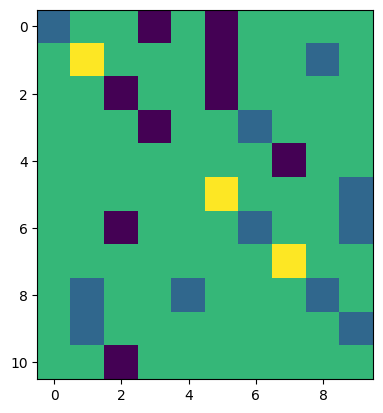

In [16]:
plt.imshow(a[30])
plt.show()

Below we have the structure of the convolutional network.

In [54]:
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(50, (5, 5), strides=1, padding="same", activation="relu", input_shape=(11,10,1)))   
model.add(MaxPool2D((2, 2), strides=1, padding="same"))
model.add(Conv2D(25,(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPool2D((2, 2), strides=1, padding="same"))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units=128, activation="sigmoid"))
model.add(Dense(units=64, activation="sigmoid"))
model.add(Dense(units=32, activation="sigmoid"))


model.add(Dense(units=num_categories, activation="softmax"))
model.compile(loss="binary_crossentropy", metrics=["accuracy"],optimizer='rmsprop')

C:\Users\gsevr\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fitting the model.

Epoch 1/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5087 - loss: 0.6931 - val_accuracy: 0.6361 - val_loss: 0.6466
Epoch 2/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6638 - loss: 0.6236 - val_accuracy: 0.6890 - val_loss: 0.5606
Epoch 3/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7423 - loss: 0.5060 - val_accuracy: 0.7410 - val_loss: 0.5045
Epoch 4/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7501 - loss: 0.4904 - val_accuracy: 0.7306 - val_loss: 0.5116
Epoch 5/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7520 - loss: 0.4833 - val_accuracy: 0.7595 - val_loss: 0.4712
Epoch 6/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7616 - loss: 0.4717 - val_accuracy: 0.7639 - val_loss: 0.4646
Epoch 7/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7644 - loss: 0.4616 - val_accuracy: 0.7613 - val_loss: 0.4686
Epoch 8/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7685 - loss: 0.4593 - val_accuracy: 0.

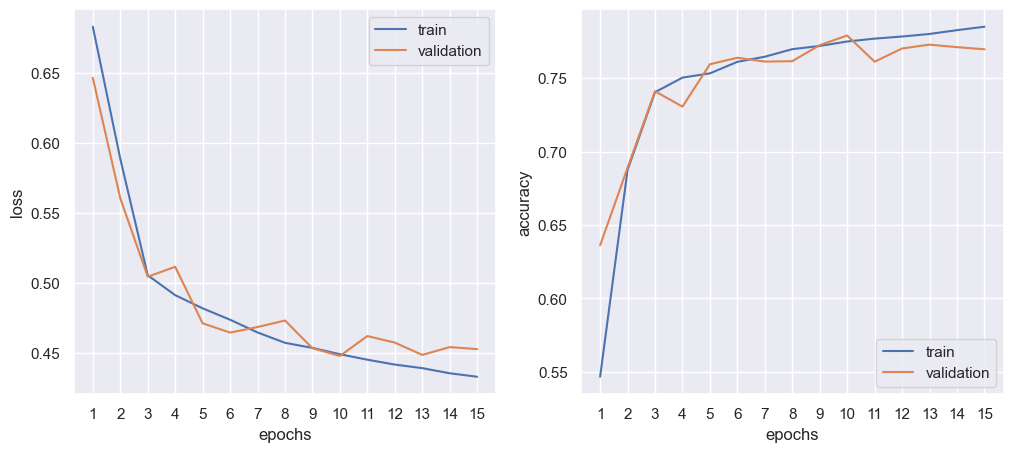

809/809 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
              precision    recall  f1-score   support

           0       0.90      0.66      0.76     12915
           1       0.73      0.93      0.82     12944

    accuracy                           0.79     25859
   macro avg       0.81      0.79      0.79     25859
weighted avg       0.81      0.79      0.79     25859



In [55]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=5,verbose=1,monitor='val_accuracy')

history = model.fit(
    a, y_train, epochs=20, verbose=1, validation_data=(b, y_test),callbacks=[early_stopping])

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

stopped_epoch = len(history.history['loss'])

plt.figure(figsize=(12,5))

# Plot loss
plt.subplot(1,2,1)
plt.plot(range(1, stopped_epoch + 1), history.history['loss'])
plt.plot(range(1, stopped_epoch + 1), history.history['val_loss'])
plt.xticks([i for i in range(1, stopped_epoch + 1)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper right')

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(range(1, stopped_epoch + 1), history.history['accuracy'])
plt.plot(range(1, stopped_epoch + 1), history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='lower right')
plt.xticks([i for i in range(1, stopped_epoch + 1)])

plt.show()


from sklearn.metrics import classification_report
preds = model.predict(a)

print(classification_report(np.argmax(y_train,axis=1), np.argmax(preds,axis=1)))

The mean accuracy resulting from 20 epochs of training seems satisfactory. At this point we could combine the train and test sets and refit the model, so as to have more data. However, we'll avoid that for computational efficiency, given that the data is of acceptable size.

In the following lines, we're evaluating four conventional classifiers using 10-fold cross-validation.

In [56]:
model.save('pretrained_model_le.keras')
np.save('training_history_le.npy', history.history)

In [12]:
def trad_class(X_train, y_train, X_test, y_test):
    rfc = RandomForestClassifier()
    dtc = DecisionTreeClassifier()
    svc = SVC()
    knc = KNeighborsClassifier()

    clfs = [rfc, dtc, svc, knc]
    preds = {}

    for clf in clfs:
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        preds[clf] = pred
        print(classification_report(y_test,pred))

    return preds


trad_class(X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.81      0.71      0.75      5556
           1       0.74      0.83      0.78      5527

    accuracy                           0.77     11083
   macro avg       0.77      0.77      0.77     11083
weighted avg       0.77      0.77      0.77     11083

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      5556
           1       0.72      0.70      0.71      5527

    accuracy                           0.72     11083
   macro avg       0.72      0.72      0.72     11083
weighted avg       0.72      0.72      0.72     11083

              precision    recall  f1-score   support

           0       0.82      0.58      0.68      5556
           1       0.67      0.87      0.76      5527

    accuracy                           0.73     11083
   macro avg       0.75      0.73      0.72     11083
weighted avg       0.75      0.73      0.72     11083

              preci

{RandomForestClassifier(): array([0, 1, 1, ..., 1, 0, 1], dtype=int64),
 DecisionTreeClassifier(): array([0, 1, 0, ..., 1, 1, 0], dtype=int64),
 SVC(): array([0, 1, 1, ..., 1, 0, 1], dtype=int64),
 KNeighborsClassifier(): array([1, 1, 1, ..., 1, 0, 1], dtype=int64)}

In [50]:
shot_dist = X_train[['3pt','close','mid']]
timeout = X_train[['timeout_away','timeout_home']]
sub = X_train[['sub_away', 'sub_home']]
shooter = X_train[['shooter_away','shooter_home']]
rebounder = X_train[['rebounder_away', 'rebounder_home']]
blocker = X_train[['blocker_away','blocker_home']]
fouler = X_train[['fouler_away','fouler_home']]
fouled = X_train[['fouled_away','fouled_home']]
rebound = X_train[['defensive','offensive']]
violation = X_train[['violation_away', 'violation_home']]
ft = X_train[['ft_away','ft_home']]
turnover = X_train[['turnover_away', 'turnover_home']]
turnover_cause = X_train[['steal']]
turnover_causer = X_train[['to_causer_away','to_causer_home']]
foul = X_train[['foul_away','foul_home']]
violator = X_train[['violator_away','violator_home']]
to_player = X_train[['to_player_away','to_player_home']]

feats = [shot_dist,timeout,sub,shooter,rebounder,blocker,fouler,fouled,rebound,violation,ft,turnover,turnover_cause,turnover_causer,foul,violator,to_player]

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


encodings = []

for feat in feats:
    input_dim = feat.shape[1]
    encoding_dim = 1  # Dimension of the latent space for clustering

    input_data = Input(shape=(input_dim,))

    # Encoder
    encoded = Dense(128, activation='relu', name='128_encoder')(input_data)
    encoded = Dense(64, activation='relu', name='64_encoder')(encoded)
    encoded = Dense(32, activation='relu', name='32_encoder')(encoded)
    encoded = Dense(encoding_dim, activation='relu', name='output_encoder')(encoded)

    # Decoder
    decoded = Dense(32, activation='relu', name='32_decoder')(encoded)
    decoded = Dense(64, activation='relu', name='64_decoder')(decoded)
    decoded = Dense(128, activation='relu', name='128_decoder')(decoded)
    decoded = Dense(input_dim, activation='tanh', name='output_decoder')(decoded)

    # Autoencoder
    autoencoder = Model(input_data, decoded)

    autoencoder.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = autoencoder.fit(feat, feat,
                    epochs=5,
                    batch_size=16,
                    shuffle=True,
                    validation_split=0.2,
                    callbacks=[early_stopping])
    
    # Dim Reduction
    encoder = Model(input_data, encoded)
    x_encoded = encoder.predict(feat)
    encodings.append(x_encoded)



In [58]:
df_dr = pd.DataFrame()

for dr in encodings:
    df_dr = pd.concat([df_dr,pd.DataFrame(dr)],axis=1)

df_dr.columns = ['shot_dist','timeout','sub','shooter','rebounder','blocker','fouler','fouled','rebound','violation','ft','turnover','turnover_cause','turnover_causer','foul','violator','to_player']
df_dr

,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0.919924,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.459396,0.0,0.0,0.0,0.000000,0.0
1,0.000000,0.0,0.0,0.00000,2.974715,0.0,0.0,0.0,2.336339,0.459396,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.459396,0.0,0.0,0.0,0.000000,0.0
3,2.062731,0.0,0.0,1.86442,0.000000,0.0,0.0,0.0,0.000000,0.459396,0.0,0.0,0.0,0.000000,0.0
4,0.919924,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.459396,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49549,2.062731,0.0,0.0,1.86442,0.000000,0.0,0.0,0.0,0.000000,0.459396,0.0,0.0,0.0,0.000000,0.0
49550,2.062731,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.459396,0.0,0.0,0.0,0.000000,0.0
49551,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.459396,0.0,0.0,0.0,0.000000,0.0
49552,0.919924,0.0,0.0,1.86442,0.000000,0.0,0.0,0.0,0.000000,0.459396,0.0,0.0,0.0,0.000000,0.0


In [19]:
combined_df = pd.read_csv('comb_df.csv',index_col=0)
df = pd.DataFrame()
encoders = []

for column in combined_df.columns[:-1]:
    le = LabelEncoder()
    encoders.append(le)
    df[column] = le.fit_transform(combined_df[column])

df = pd.concat([df,combined_df.iloc[:,-1]],axis=1)

C:\Users\gsevr\AppData\Local\Temp\ipykernel_21880\485131485.py:1: DtypeWarning: Columns (105) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv('comb_df.csv',index_col=0)
C:\Users\gsevr\AppData\Local\Temp\ipykernel_21880\485131485.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column] = le.fit_transform(combined_df[column])
C:\Users\gsevr\AppData\Local\Temp\ipykernel_21880\485131485.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column] = le.fit_transform(combin

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prefixspan import PrefixSpan

# Step 2: Reshape data
def reshape_data(data):
    sequences = []
    for row in data:
        sequence = []
        is_nan_sequence = True
        for i in range(10):  # 10 events
            event = row[i*11:(i+1)*11]  # 11 features per event
            if not np.all(np.isnan(event)):  # Check if the event is not all NaN
                is_nan_sequence = False
            sequence.append(tuple(event))  # Convert event to a tuple
        if not is_nan_sequence:  # Only add sequences that are not all NaN
            sequences.append(sequence)
    return sequences

# Assuming combined_df is your DataFrame with the data
sequences = reshape_data(combined_df.iloc[:,:-5])  # Ensure to pass values for numpy operations

# Step 3: Convert sequences for PrefixSpan
sequences_for_prefixspan = [list(map(str, seq)) for seq in sequences]  # Convert tuples to strings

# Step 4: Initialize PrefixSpan and find frequent patterns
ps = PrefixSpan(sequences_for_prefixspan)
frequent_patterns = ps.frequent(minsup=0.1)

# Step 5: Convert patterns to DataFrame and sort
patterns_df = pd.DataFrame(frequent_patterns, columns=['sequence', 'support'])
sorted_patterns_df = patterns_df.sort_values(by='support', ascending=False)

# Step 6: Display top N frequent patterns
top_n = 10
top_patterns = sorted_patterns_df.head(top_n)
print(top_patterns)

# Step 7: Visualize top frequent patterns
top_patterns['sequence'] = top_patterns['sequence'].apply(lambda x: ' -> '.join(map(str, x)))

plt.figure(figsize=(10, 6))
plt.barh(top_patterns['sequence'], top_patterns['support'])
plt.xlabel('Support')
plt.ylabel('Frequent Sequences')
plt.title('Top Frequent Sequences')
plt.gca().invert_yaxis()
plt.show()


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [32]:
combined_df[combined_df.duplicated()]

,ShotDist1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,ReboundType1,ViolationPlayer1,FreeThrowShooter1,TurnoverPlayer1,ShotDist2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,ReboundType2,ViolationPlayer2,FreeThrowShooter2,TurnoverPlayer2,ShotDist3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,ReboundType3,ViolationPlayer3,FreeThrowShooter3,TurnoverPlayer3,ShotDist4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,ReboundType4,ViolationPlayer4,FreeThrowShooter4,TurnoverPlayer4,ShotDist5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,ReboundType5,ViolationPlayer5,FreeThrowShooter5,TurnoverPlayer5,ShotDist6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,ReboundType6,ViolationPlayer6,FreeThrowShooter6,TurnoverPlayer6,ShotDist7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,ReboundType7,ViolationPlayer7,FreeThrowShooter7,TurnoverPlayer7,ShotDist8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,ReboundType8,ViolationPlayer8,FreeThrowShooter8,TurnoverPlayer8,ShotDist9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,ReboundType9,ViolationPlayer9,FreeThrowShooter9,TurnoverPlayer9,ShotDist10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,ReboundType10,ViolationPlayer10,FreeThrowShooter10,TurnoverPlayer10,class
2657,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,mid,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3739,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_home,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,1
4039,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_home,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,1
5081,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,1
5747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,close,NaN,NaN,shooter_away,NaN,blocker_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,close,NaN,NaN,shooter_home,Na

In [33]:
asd = df[df['class'] ==1]
a = []
for column in combined_df.columns:
    a.append(combined_df[column].value_counts())


In [12]:
clf = DecisionTreeClassifier()
clf.fit(df.iloc[:,:-1],df.iloc[:,-1])
preds = clf.predict(df.iloc[:,:-1])

In [ ]:
X = df[combined_df.columns[:-1]]
y = df['class']

def decode_features(X, encoders, columns):
    decoded_X = X.copy()
    for i, column in enumerate(columns):
        decoded_X[column] = encoders[i].inverse_transform(X[column])
    return decoded_X

# Decode the features
decoded_X = decode_features(X, encoders, combined_df.columns[:-1])

# Map the feature values in the tree
def get_decoded_tree(clf, encoders, feature_names):
    from sklearn.tree import _tree
    
    tree_ = clf.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            threshold_value = encoders[combined_df.columns.get_loc(name)].inverse_transform([int(threshold + 0.5)])[0]
            print(f"{indent}if {name} <= {threshold_value}:")
            recurse(tree_.children_left[node], depth + 1)
            print(f"{indent}else:  # if {name} > {threshold_value}")
            recurse(tree_.children_right[node], depth + 1)
        else:
            print(f"{indent}return {clf.classes_[np.argmax(tree_.value[node])]}")
    
    recurse(0, 0)

# Get and print the decoded tree
get_decoded_tree(clf, encoders, combined_df.columns[:-1])

# Get the tree in DOT format
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=combined_df.columns[:-1],
                           class_names=[str(i) for i in df['class'].unique()],
                           filled=True, rounded=True, 
                           special_characters=True)

In [20]:
clf

DecisionTreeClassifier()

In [16]:
import graphviz

graph = graphviz.Source(dot_data) 
graph.render("le_tree")

'le_tree.pdf'

In [63]:
import graphviz
from sklearn.tree import export_graphviz

tree = rf.estimators_[0]
dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=df.columns[:-1], 
                           class_names=df.columns[-1], 
                           filled=True, rounded=True, 
                           special_characters=True) 


graph = graphviz.Source(dot_data) 
graph.render("le_tree")


Our second goal is to identify the frequency of specific values in our features.

In [52]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder
import graphviz

# Sample data
data = {
    'feature1': ['A', 'B', 'A', 'C', 'B'],
    'feature2': ['X', 'Y', 'Y', 'X', 'X'],
    'target': ['cat', 'dog', 'dog', 'mouse', 'cat']
}

df = pd.DataFrame(data)

# Step 1: Encode the labels for each column using LabelEncoders
encoders = {col: LabelEncoder().fit(df[col]) for col in df.columns}

# Transform the dataframe
df_encoded = df.copy()
for col, encoder in encoders.items():
    df_encoded[col] = encoder.transform(df[col])

# Separate features and target
X = df_encoded[['feature1', 'feature2']]
y = df_encoded['target']

# Step 2: Train the decision tree on the encoded labels
clf = DecisionTreeClassifier()
clf.fit(X, y)

# Step 3: Prepare to visualize the tree
# Define a function to decode labels
def decode_labels(encoded_labels, label_encoder):
    return [label_encoder.inverse_transform([label])[0] for label in encoded_labels]

# Decode the class names for the target
class_names = decode_labels(clf.classes_, encoders['target'])

# Decode the feature names
feature_names = [decode_labels([i], encoders[col])[0] for i, col in enumerate(X.columns)]

# Get the tree in DOT format
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=feature_names,
                           class_names=class_names,
                           filled=True, rounded=True, 
                           special_characters=True)

# Visualize the tree using graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree_with_original_labels")  # Save the tree as a file
graph.view()  # Open the tree visualization


'decision_tree_with_original_labels.pdf'

In [ ]:
dec_df = combined_test_df.dropna().astype(int)

for factor in factors:
    for i in range(1,11):
        dec_df[factor+str(i)] = globals()[f'{factor}_le'].inverse_transform(dec_df[factor+str(i)])